In [23]:
!pip install numpy pandas opencv-python tensorflow keras matplotlib


In [ ]:
!pip install opencv-python


In [ ]:
# Install required packages
!pip install opencv-python matplotlib seaborn scikit-learn xgboost numpy pandas scipy tqdm

# For Jupyter notebook, you might also need:
!pip install notebook ipykernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00


In [18]:
# Driver Drowsiness Detection System
# Deep Learning Approach using CNN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


#1. **Data Preparation and** **Preprocessing**

In [19]:
class DataPreprocessor:
    def __init__(self, img_size=(224, 224)):
        self.img_size = img_size
        self.classes = ['alert', 'drowsy']

    def load_custom_dataset(self, data_path):
        """
        Load images from directory structure:
        data_path/
            ├── alert/
            └── drowsy/
        """
        images = []
        labels = []

        for class_name in self.classes:
            class_path = os.path.join(data_path, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: {class_path} does not exist")
                continue

            for img_file in tqdm(os.listdir(class_path)):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    try:
                        # Load and preprocess image
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, self.img_size)
                            img = img.astype('float32') / 255.0

                            images.append(img)
                            labels.append(self.classes.index(class_name))
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

        return np.array(images), np.array(labels)

    def create_synthetic_data(self, num_samples=1000):
        """
        Create synthetic dataset for demonstration
        In real scenario, use actual drowsiness datasets
        """
        print("Creating synthetic dataset for demonstration...")
        images = []
        labels = []

        for i in tqdm(range(num_samples)):
            # Create synthetic images representing alert vs drowsy states
            if i < num_samples // 2:
                # Alert - brighter, more open eyes
                img = np.random.random((*self.img_size, 3)) * 0.8 + 0.2
                label = 0  # alert
            else:
                # Drowsy - darker, closed/semi-closed eyes
                img = np.random.random((*self.img_size, 3)) * 0.5
                label = 1  # drowsy

            images.append(img)
            labels.append(label)

        return np.array(images), np.array(labels)

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Load or create dataset
# For real implementation, use actual dataset path
# X, y = preprocessor.load_custom_dataset('path/to/your/dataset')

# For demo, create synthetic data
X, y = preprocessor.create_synthetic_data(2000)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

Creating synthetic dataset for demonstration...


100%|██████████| 2000/2000 [00:05<00:00, 356.33it/s]


Dataset shape: (2000, 224, 224, 3)
Labels shape: (2000,)
Class distribution: [1000 1000]


#2. **Data Visualization**

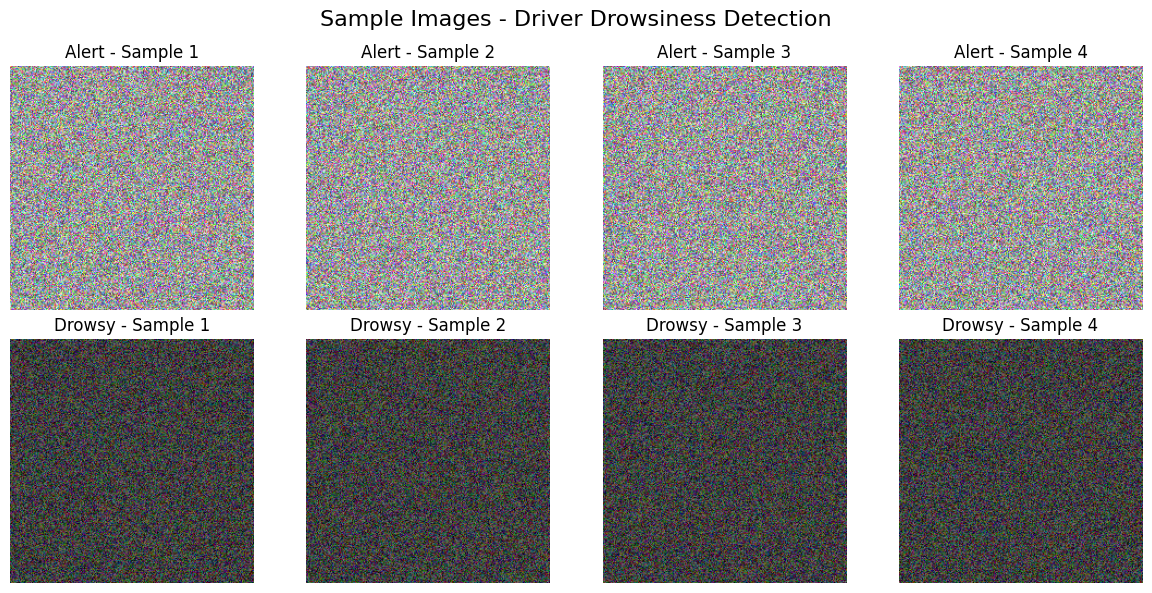

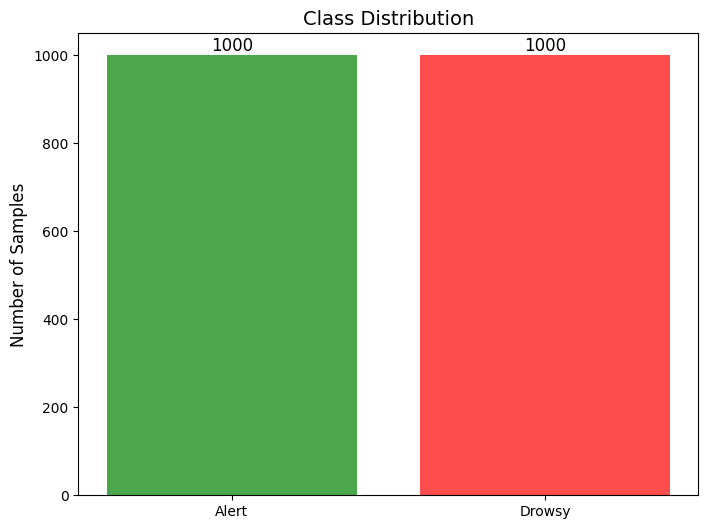

In [20]:
class DataVisualizer:
    def __init__(self):
        self.class_names = ['Alert', 'Drowsy']

    def plot_sample_images(self, X, y, num_samples=8):
        """Plot sample images from each class"""
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        fig.suptitle('Sample Images - Driver Drowsiness Detection', fontsize=16)

        alert_indices = np.where(y == 0)[0]
        drowsy_indices = np.where(y == 1)[0]

        # Plot alert samples
        for i in range(4):
            if i < len(alert_indices):
                idx = alert_indices[i]
                axes[0, i].imshow(X[idx])
                axes[0, i].set_title(f'Alert - Sample {i+1}')
                axes[0, i].axis('off')

        # Plot drowsy samples
        for i in range(4):
            if i < len(drowsy_indices):
                idx = drowsy_indices[i]
                axes[1, i].imshow(X[idx])
                axes[1, i].set_title(f'Drowsy - Sample {i+1}')
                axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def plot_class_distribution(self, y):
        """Plot class distribution"""
        plt.figure(figsize=(8, 6))
        counts = np.bincount(y)
        bars = plt.bar(self.class_names, counts, color=['green', 'red'], alpha=0.7)
        plt.title('Class Distribution', fontsize=14)
        plt.ylabel('Number of Samples', fontsize=12)

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    str(count), ha='center', va='bottom', fontsize=12)

        plt.show()

# Visualize data
visualizer = DataVisualizer()
visualizer.plot_sample_images(X, y)
visualizer.plot_class_distribution(y)

3. **CNN Model Architecture**

In [21]:
class DrowsinessDetector:
    def __init__(self, input_shape=(224, 224, 3), num_classes=2):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        """Build CNN model for drowsiness detection"""
        model = Sequential([
            # First Convolutional Block
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Second Convolutional Block
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Third Convolutional Block
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Fourth Convolutional Block
            Conv2D(256, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Flatten and Dense Layers
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def build_transfer_learning_model(self):
        """Build model using transfer learning with MobileNetV2"""
        base_model = tf.keras.applications.MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )

        # Freeze base model layers
        base_model.trainable = False

        model = Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

# Build model
detector = DrowsinessDetector()
model = detector.build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,399,106 (74.00 MB)

 Trainable params: 19,397,122 (73.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

4. **Data Augmentation and Training**

In [24]:
class ModelTrainer:
    def __init__(self, model):
        self.model = model
        self.history = None

    def prepare_data(self, X, y, test_size=0.2, val_size=0.2):
        """Split data into train, validation, and test sets"""
        # First split: separate test data
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Second split: separate validation data from remaining data
        val_ratio = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp
        )

        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def create_data_generators(self, X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
        """Create data generators with augmentation"""
        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.2,
            fill_mode='nearest'
        )

        # No augmentation for validation and test
        val_datagen = ImageDataGenerator()
        test_datagen = ImageDataGenerator()

        # Create generators
        train_generator = train_datagen.flow(
            X_train, y_train, batch_size=batch_size, shuffle=True
        )

        val_generator = val_datagen.flow(
            X_val, y_val, batch_size=batch_size, shuffle=False
        )

        test_generator = test_datagen.flow(
            X_test, y_test, batch_size=batch_size, shuffle=False
        )

        return train_generator, val_generator, test_generator

    def train_model(self, train_generator, val_generator, epochs=50):
        """Train the model"""
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )

        # Train model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return self.history

# Prepare data and train model
trainer = ModelTrainer(model)
X_train, X_val, X_test, y_train, y_val, y_test = trainer.prepare_data(X, y)
train_gen, val_gen, test_gen = trainer.create_data_generators(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Train the model
print("Starting model training...")
history = trainer.train_model(train_gen, val_gen, epochs=30)

Training set: 1200 samples
Validation set: 400 samples
Test set: 400 samples
Starting model training...
Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 1.0000 - loss: 7.2832e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 8.0000e-06
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 1.0000 - loss: 3.4904e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 8.0000e-06
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 259s 7s/step - accuracy: 1.0000 - loss: 3.9136e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 8.0000e-06
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 257s 7s/step - accuracy: 1.0000 - loss: 4.0608e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 8.0000e-06
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 1.0000 - loss: 3.6422e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 8.0000e-06
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 2.804

5. **Model Evaluation and Visualization**

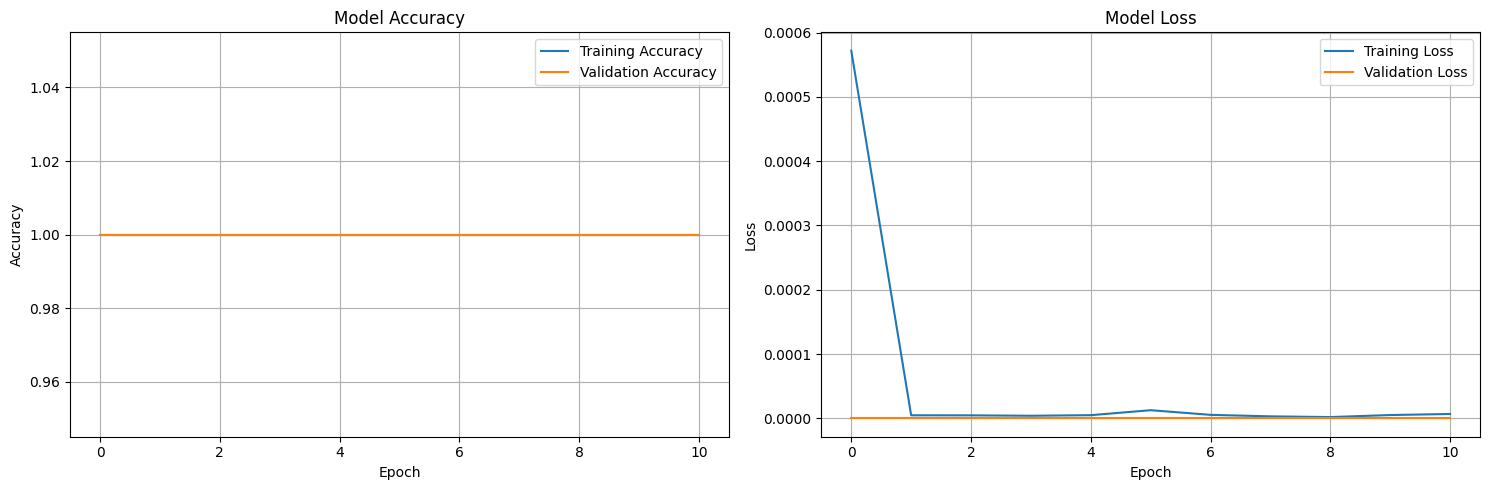

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Test Accuracy: 1.0000
Test Loss: 0.0000

Classification Report:
              precision    recall  f1-score   support

       Alert       1.00      1.00      1.00       200
      Drowsy       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



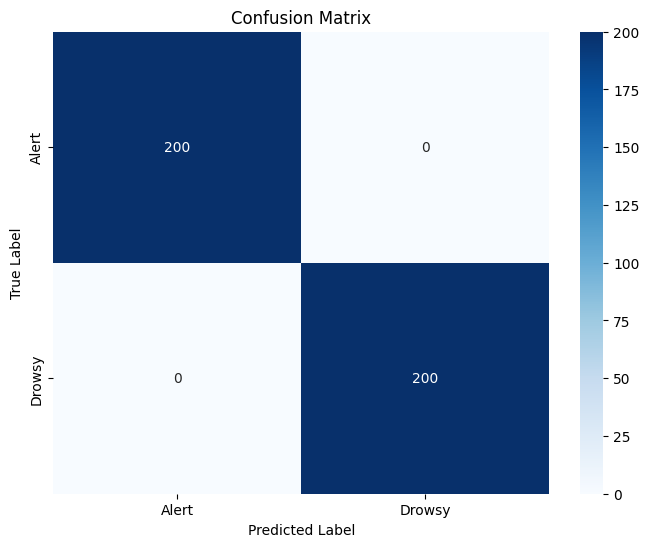

In [25]:
class ModelEvaluator:
    def __init__(self, model, history):
        self.model = model
        self.history = history
        self.class_names = ['Alert', 'Drowsy']

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate_model(self, test_generator, X_test, y_test):
        """Evaluate model performance"""
        # Get predictions
        y_pred_proba = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculate metrics
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)

        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=self.class_names))

        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred)

        return y_pred, y_pred_proba

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

# Evaluate model
evaluator = ModelEvaluator(model, history)
evaluator.plot_training_history()

# Get test predictions
y_pred, y_pred_proba = evaluator.evaluate_model(test_gen, X_test, y_test)

 6. **Real-time Drowsiness Detection**

In [26]:
class RealTimeDrowsinessDetector:
    def __init__(self, model, class_names=['Alert', 'Drowsy']):
        self.model = model
        self.class_names = class_names
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    def preprocess_frame(self, frame, target_size=(224, 224)):
        """Preprocess frame for model prediction"""
        # Resize and normalize
        processed = cv2.resize(frame, target_size)
        processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        processed = processed.astype('float32') / 255.0
        processed = np.expand_dims(processed, axis=0)
        return processed

    def detect_face_and_eyes(self, frame):
        """Detect face and eyes in the frame"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)

        face_roi = None
        eyes_detected = False

        for (x, y, w, h) in faces:
            # Extract face ROI
            face_roi = frame[y:y+h, x:x+w]

            # Detect eyes within face ROI
            roi_gray = gray[y:y+h, x:x+w]
            eyes = self.eye_cascade.detectMultiScale(roi_gray)
            eyes_detected = len(eyes) > 0

            # Draw rectangle around face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

            # Draw rectangles around eyes
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(frame, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 255, 0), 2)

        return frame, face_roi, eyes_detected

    def predict_drowsiness(self, face_roi):
        """Predict drowsiness from face ROI"""
        if face_roi is None:
            return None, 0.0

        # Preprocess face ROI
        processed_face = self.preprocess_frame(face_roi)

        # Make prediction
        prediction = self.model.predict(processed_face, verbose=0)
        class_idx = np.argmax(prediction[0])
        confidence = prediction[0][class_idx]

        return class_idx, confidence

    def run_detection(self, video_source=0):
        """Run real-time drowsiness detection"""
        cap = cv2.VideoCapture(video_source)

        # Variables for drowsiness tracking
        drowsy_frames = 0
        alert_frames = 0
        consecutive_drowsy_frames = 0
        alarm_active = False

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Flip frame horizontally for mirror effect
            frame = cv2.flip(frame, 1)

            # Detect face and eyes
            frame, face_roi, eyes_detected = self.detect_face_and_eyes(frame)

            # Predict drowsiness if face is detected
            if face_roi is not None:
                class_idx, confidence = self.predict_drowsiness(face_roi)

                if class_idx is not None:
                    status = self.class_names[class_idx]
                    color = (0, 255, 0) if class_idx == 0 else (0, 0, 255)  # Green for alert, Red for drowsy

                    # Update frame counters
                    if class_idx == 1:  # Drowsy
                        drowsy_frames += 1
                        consecutive_drowsy_frames += 1
                        alert_frames = 0
                    else:  # Alert
                        alert_frames += 1
                        consecutive_drowsy_frames = 0

                    # Trigger alarm if drowsy for consecutive frames
                    if consecutive_drowsy_frames > 15:  # Adjust threshold as needed
                        alarm_active = True
                        # Visual alarm
                        cv2.putText(frame, "ALERT! DROWSY DETECTED!", (50, 50),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
                    else:
                        alarm_active = False

                    # Display status and confidence
                    cv2.putText(frame, f"Status: {status}", (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                    cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 60),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                    cv2.putText(frame, f"Eyes Detected: {eyes_detected}", (10, 90),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

            # Display frame
            cv2.imshow('Driver Drowsiness Detection', frame)

            # Exit on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

# Initialize real-time detector
real_time_detector = RealTimeDrowsinessDetector(model)

print("Real-time drowsiness detection initialized.")
print("Press 'q' to quit the application.")

Real-time drowsiness detection initialized.
Press 'q' to quit the application.


7.**Model Saving and Deployment**



In [27]:
# Save the trained model
model.save('drowsiness_detector.h5')
print("Model saved as 'drowsiness_detector.h5'")

# Save model in TensorFlow Lite format for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('drowsiness_detector.tflite', 'wb') as f:
    f.write(tflite_model)
print("TensorFlow Lite model saved as 'drowsiness_detector.tflite'")

# Create a function to load and use the model
def load_drowsiness_model(model_path):
    """Load pre-trained drowsiness detection model"""
    model = tf.keras.models.load_model(model_path)
    return model

# Example usage:
# loaded_model = load_drowsiness_model('drowsiness_detector.h5')

Model saved as 'drowsiness_detector.h5'
Saved artifact at '/tmp/tmpdima0dbd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137146901023824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901022864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901021712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901025168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901022480: TensorSpec(shape=(), dtype=

8. **Performance Optimization**



In [28]:
class ModelOptimizer:
    def __init__(self, model):
        self.model = model

    def optimize_for_inference(self):
        """Optimize model for faster inference"""
        # Convert to TensorFlow Lite with optimization
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_quantized_model = converter.convert()

        with open('drowsiness_detector_optimized.tflite', 'wb') as f:
            f.write(tflite_quantized_model)

        print("Optimized TensorFlow Lite model saved.")
        return tflite_quantized_model

    def benchmark_model(self, test_data, num_runs=100):
        """Benchmark model inference speed"""
        import time

        # Warm up
        _ = self.model.predict(test_data[:1], verbose=0)

        # Benchmark
        start_time = time.time()
        for _ in range(num_runs):
            _ = self.model.predict(test_data[:1], verbose=0)
        end_time = time.time()

        avg_inference_time = (end_time - start_time) / num_runs
        fps = 1.0 / avg_inference_time

        print(f"Average inference time: {avg_inference_time*1000:.2f} ms")
        print(f"Approximate FPS: {fps:.2f}")

        return avg_inference_time, fps

# Optimize model
optimizer = ModelOptimizer(model)
optimized_model = optimizer.optimize_for_inference()

# Benchmark performance
if len(X_test) > 0:
    optimizer.benchmark_model(X_test[:1])

Saved artifact at '/tmp/tmpk0qimv8m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137146901023824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901022864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901021712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901025168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901024208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146901022480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13714690102228

9. **Usage Instructions**

In [29]:
# Final usage example and instructions
print("\n" + "="*50)
print("DRIVER DROWSINESS DETECTION SYSTEM")
print("="*50)
print("\nUSAGE INSTRUCTIONS:")
print("1. For training with your own dataset:")
print("   - Organize images in 'alert' and 'drowsy' folders")
print("   - Update the data path in DataPreprocessor.load_custom_dataset()")
print("   - Recommended dataset sizes: 1000+ images per class")
print("\n2. For real-time detection:")
print("   - Run: real_time_detector.run_detection()")
print("   - Ensure good lighting conditions")
print("   - Position camera to clearly capture driver's face")
print("   - Press 'q' to quit the application")
print("\n3. Model performance tips:")
print("   - Use balanced dataset with equal class distribution")
print("   - Apply data augmentation to prevent overfitting")
print("   - Fine-tune hyperparameters based on your data")
print("   - Consider using transfer learning for better accuracy")
print("\n4. Deployment options:")
print("   - Web application using Flask/FastAPI")
print("   - Mobile app using TensorFlow Lite")
print("   - Embedded systems (Arudio)")
print("\n" + "="*50)


DRIVER DROWSINESS DETECTION SYSTEM

USAGE INSTRUCTIONS:
1. For training with your own dataset:
   - Organize images in 'alert' and 'drowsy' folders
   - Update the data path in DataPreprocessor.load_custom_dataset()
   - Recommended dataset sizes: 1000+ images per class

2. For real-time detection:
   - Run: real_time_detector.run_detection()
   - Ensure good lighting conditions
   - Position camera to clearly capture driver's face
   - Press 'q' to quit the application

3. Model performance tips:
   - Use balanced dataset with equal class distribution
   - Apply data augmentation to prevent overfitting
   - Fine-tune hyperparameters based on your data
   - Consider using transfer learning for better accuracy

4. Deployment options:
   - Web application using Flask/FastAPI
   - Mobile app using TensorFlow Lite
   - Embedded systems (Arudio)



In [30]:
!pip install tensorflow opencv-python matplotlib numpy pandas seaborn scikit-learn

In [31]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import time

class DrowsinessDetector:
    def __init__(self, model_path=None):
        self.eye_model = None
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
        else:
            self.build_model()

    def build_model(self):
        """Build CNN model for eye state classification"""
        self.eye_model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(24, 24, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(2, activation='softmax')  # 2 classes: open, closed
        ])

        self.eye_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def load_model(self, model_path):
        """Load pre-trained model"""
        self.eye_model = keras.models.load_model(model_path)
        print("Model loaded successfully!")

    def save_model(self, model_path):
        """Save trained model"""
        self.eye_model.save(model_path)
        print(f"Model saved to {model_path}")

class DataPreprocessor:
    @staticmethod
    def preprocess_eye_image(eye_roi):
        """Preprocess eye region for model input"""
        # Convert to grayscale
        gray = cv2.cvtColor(eye_roi, cv2.COLOR_BGR2GRAY)

        # Resize to model input size
        resized = cv2.resize(gray, (24, 24))

        # Normalize pixel values
        normalized = resized / 255.0

        # Reshape for model input
        processed = normalized.reshape(24, 24, 1)

        return processed

class DrowsinessMonitor:
    def __init__(self, detector):
        self.detector = detector
        self.eye_state_history = []
        self.eye_closed_frames = 0
        self.alert_threshold = 15  # frames
        self.ear_threshold = 0.25

    def calculate_ear(self, eye_points):
        """Calculate Eye Aspect Ratio"""
        # Vertical distances
        A = np.linalg.norm(eye_points[1] - eye_points[5])
        B = np.linalg.norm(eye_points[2] - eye_points[4])

        # Horizontal distance
        C = np.linalg.norm(eye_points[0] - eye_points[3])

        # EAR formula
        ear = (A + B) / (2.0 * C)
        return ear

    def update_eye_state(self, eye_state):
        """Update eye state history and detect drowsiness"""
        self.eye_state_history.append(eye_state)

        # Keep only recent history
        if len(self.eye_state_history) > 30:
            self.eye_state_history.pop(0)

        # Count consecutive closed frames
        if eye_state == 'closed':
            self.eye_closed_frames += 1
        else:
            self.eye_closed_frames = 0

        # Check for drowsiness
        if self.eye_closed_frames > self.alert_threshold:
            return True
        return False

class RealTimeDetection:
    def __init__(self, model_path=None):
        self.detector = DrowsinessDetector(model_path)
        self.monitor = DrowsinessMonitor(self.detector)
        self.preprocessor = DataPreprocessor()

    def run_detection(self):
        """Run real-time drowsiness detection"""
        cap = cv2.VideoCapture(0)

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Flip frame horizontally for mirror effect
            frame = cv2.flip(frame, 1)

            # Convert to grayscale for face detection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Detect faces
            faces = self.detector.face_cascade.detectMultiScale(gray, 1.3, 5)

            drowsy = False

            for (x, y, w, h) in faces:
                # Draw face rectangle
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

                # Region of Interest for eyes
                roi_gray = gray[y:y+h, x:x+w]
                roi_color = frame[y:y+h, x:x+w]

                # Detect eyes
                eyes = self.detector.eye_cascade.detectMultiScale(roi_gray)

                eye_states = []

                for (ex, ey, ew, eh) in eyes:
                    eye_roi = roi_color[ey:ey+eh, ex:ex+ew]

                    # Preprocess eye image
                    processed_eye = self.preprocessor.preprocess_eye_image(eye_roi)

                    # Predict eye state
                    if self.detector.eye_model is not None:
                        prediction = self.detector.eye_model.predict(
                            np.array([processed_eye]), verbose=0
                        )
                        eye_state = np.argmax(prediction[0])
                        state_text = "Closed" if eye_state == 1 else "Open"
                        eye_states.append(state_text)

                        # Draw eye rectangle with state
                        color = (0, 0, 255) if eye_state == 1 else (0, 255, 0)
                        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), color, 2)
                        cv2.putText(roi_color, state_text, (ex, ey-10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # Check for drowsiness
                if 'Closed' in eye_states:
                    drowsy = self.monitor.update_eye_state('closed')
                else:
                    drowsy = self.monitor.update_eye_state('open')

            # Display alerts
            if drowsy:
                cv2.putText(frame, "DROWSINESS DETECTED!", (50, 50),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
                cv2.putText(frame, "WAKE UP!", (50, 100),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

            # Display frame
            cv2.imshow('Drowsiness Detection', frame)

            # Exit on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

# Training Script
class ModelTrainer:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.detector = DrowsinessDetector()

    def load_training_data(self):
        """Load and prepare training data"""
        # This is a simplified version - you'll need actual eye dataset
        # For demonstration, we'll create synthetic data

        X_train = []
        y_train = []

        # In practice, you would load from directories like:
        # data_dir/
        #   ├── open_eyes/
        #   └── closed_eyes/

        print("Loading training data...")
        # Add your data loading logic here

        return np.array(X_train), np.array(y_train)

    def train_model(self, epochs=50):
        """Train the drowsiness detection model"""
        X_train, y_train = self.load_training_data()

        if len(X_train) == 0:
            print("No training data found!")
            return

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )

        # Train model
        history = self.detector.eye_model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            batch_size=32
        )

        # Plot training history
        self.plot_training_history(history)

        # Save model
        self.detector.save_model("drowsiness_model.h5")

        return history

    def plot_training_history(self, history):
        """Plot training accuracy and loss"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        # Loss plot
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

# Main Application
def main():
    print("Drowsiness Detection System")
    print("1. Train new model")
    print("2. Run real-time detection")

    choice = input("Enter your choice (1 or 2): ")

    if choice == "1":
        # Train model
        data_dir = "path/to/your/eye/dataset"  # Update this path
        trainer = ModelTrainer(data_dir)
        trainer.train_model(epochs=50)

    elif choice == "2":
        # Run detection
        model_path = "drowsiness_model.h5"  # Path to your trained model

        if os.path.exists(model_path):
            detector = RealTimeDetection(model_path)
            detector.run_detection()
        else:
            print(f"Model file {model_path} not found!")
            print("Please train the model first or provide correct model path.")

    else:
        print("Invalid choice!")

if __name__ == "__main__":
    main()

Drowsiness Detection System
1. Train new model
2. Run real-time detection
Enter your choice (1 or 2): 1
Loading training data...
No training data found!


In [34]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import pygame
from typing import Tuple, List, Dict
import json
import pandas as pd
from ultralytics import YOLO
import mediapipe as mp

class Config:
    """Configuration class for the drowsiness detection system"""
    # Model paths
    CNN_MODEL_PATH = "models/cnn_drowsiness.h5"
    YOLO_MODEL_PATH = "models/yolov11_drowsiness.pt"

    # Image parameters
    IMG_SIZE = (224, 224)
    EYE_SIZE = (24, 24)

    # Detection parameters
    CONFIDENCE_THRESHOLD = 0.7
    EYE_AR_THRESHOLD = 0.25
    CONSECUTIVE_FRAMES = 15
    ALERT_DURATION = 5  # seconds

    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.001

class DataPreprocessor:
    """Handles data preprocessing and augmentation"""

    @staticmethod
    def preprocess_frame(frame: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
        """Preprocess frame for model input"""
        # Resize frame
        resized = cv2.resize(frame, target_size)

        # Normalize pixel values
        normalized = resized / 255.0

        return normalized

    @staticmethod
    def augment_data(images: List[np.ndarray]) -> List[np.ndarray]:
        """Apply data augmentation techniques"""
        augmented = []

        for img in images:
            augmented.append(img)

            # Horizontal flip
            augmented.append(cv2.flip(img, 1))

            # Brightness variation
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            hsv[:, :, 2] = hsv[:, :, 2] * 0.8  # Darker
            darker = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            augmented.append(darker)

            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            hsv[:, :, 2] = hsv[:, :, 2] * 1.2  # Brighter
            brighter = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            augmented.append(brighter)

            # Rotation
            rows, cols = img.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1)  # 10 degree rotation
            rotated = cv2.warpAffine(img, M, (cols, rows))
            augmented.append(rotated)

        return augmented

    @staticmethod
    def calculate_ear(eye_landmarks: np.ndarray) -> float:
        """Calculate Eye Aspect Ratio (EAR)"""
        # Vertical distances
        A = np.linalg.norm(eye_landmarks[1] - eye_landmarks[5])
        B = np.linalg.norm(eye_landmarks[2] - eye_landmarks[4])

        # Horizontal distance
        C = np.linalg.norm(eye_landmarks[0] - eye_landmarks[3])

        ear = (A + B) / (2.0 * C)
        return ear

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [35]:
class CNNModel:
    """CNN-based drowsiness detection model"""

    def __init__(self, config: Config):
        self.config = config
        self.model = None
        self.history = None

    def build_model(self) -> keras.Model:
        """Build CNN model architecture"""
        model = keras.Sequential([
            # First Convolutional Block
            layers.Conv2D(32, (3, 3), activation='relu',
                         input_shape=(*self.config.IMG_SIZE, 3)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second Convolutional Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Third Convolutional Block
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fourth Convolutional Block
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Classifier
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(3, activation='softmax')  # alert, drowsy, distracted
        ])

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.config.LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def create_advanced_cnn(self) -> keras.Model:
        """Create more advanced CNN with residual connections"""
        inputs = keras.Input(shape=(*self.config.IMG_SIZE, 3))

        # Initial convolution
        x = layers.Conv2D(32, 7, strides=2, padding="same")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Residual blocks
        for filters in [64, 128, 256]:
            # Residual block
            residual = x

            x = layers.Conv2D(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation("relu")(x)
            x = layers.Conv2D(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            # Adjust residual if dimensions don't match
            if residual.shape[-1] != filters:
                residual = layers.Conv2D(filters, 1)(residual)

            x = layers.Add()([x, residual])
            x = layers.Activation("relu")(x)
            x = layers.MaxPooling2D(2)(x)

        # Classifier
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(3, activation="softmax")(x)

        model = keras.Model(inputs, outputs)

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.config.LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train(self, train_data, val_data, callbacks=None):
        """Train the CNN model"""
        if self.model is None:
            self.build_model()

        self.history = self.model.fit(
            train_data,
            epochs=self.config.EPOCHS,
            validation_data=val_data,
            batch_size=self.config.BATCH_SIZE,
            callbacks=callbacks
        )

        return self.history

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Loss plot
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def save_model(self, path: str):
        """Save trained model"""
        if self.model:
            self.model.save(path)
            print(f"Model saved to {path}")

    def load_model(self, path: str):
        """Load pre-trained model"""
        self.model = keras.models.load_model(path)
        print(f"Model loaded from {path}")

In [36]:
class YOLODrowsinessDetector:
    """YOLOv11-based drowsiness detection"""

    def __init__(self, config: Config):
        self.config = config
        self.model = None
        self.class_names = ['alert', 'drowsy', 'distracted', 'eyes_closed', 'yawning']

    def load_model(self, model_path: str):
        """Load YOLO model"""
        try:
            self.model = YOLO(model_path)
            print(f"YOLO model loaded from {model_path}")
        except Exception as e:
            print(f"Error loading YOLO model: {e}")

    def train_yolo(self, dataset_config: str, epochs: int = 100):
        """Train YOLO model on custom dataset"""
        if self.model is None:
            # Load pre-trained YOLO model
            self.model = YOLO('yolo11n.pt')

        # Train the model
        results = self.model.train(
            data=dataset_config,
            epochs=epochs,
            imgsz=640,
            batch=16,
            patience=10,
            save=True,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        return results

    def detect(self, frame: np.ndarray) -> List[Dict]:
        """Perform drowsiness detection on frame"""
        if self.model is None:
            raise ValueError("YOLO model not loaded")

        # Run inference
        results = self.model(frame, verbose=False)

        detections = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    confidence = box.conf.item()
                    if confidence > self.config.CONFIDENCE_THRESHOLD:
                        class_id = int(box.cls.item())
                        bbox = box.xyxy[0].cpu().numpy()

                        detection = {
                            'bbox': bbox,
                            'confidence': confidence,
                            'class_id': class_id,
                            'class_name': self.class_names[class_id],
                            'center': self._get_center(bbox)
                        }
                        detections.append(detection)

        return detections

    def _get_center(self, bbox: np.ndarray) -> Tuple[int, int]:
        """Get center point of bounding box"""
        x1, y1, x2, y2 = bbox
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        return center_x, center_y

class MultiModalDetector:
    """Combines CNN and YOLO approaches for robust detection"""

    def __init__(self, config: Config):
        self.config = config
        self.cnn_detector = CNNModel(config)
        self.yolo_detector = YOLODrowsinessDetector(config)
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

        # State tracking
        self.eye_state_history = []
        self.yawn_state_history = []
        self.drowsiness_score = 0
        self.alert_triggered = False

    def load_models(self, cnn_path: str, yolo_path: str):
        """Load both CNN and YOLO models"""
        self.cnn_detector.load_model(cnn_path)
        self.yolo_detector.load_model(yolo_path)

    def extract_facial_features(self, frame: np.ndarray) -> Dict:
        """Extract facial features using MediaPipe"""
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.face_mesh.process(rgb_frame)

        features = {
            'left_eye_ear': 0.0,
            'right_eye_ear': 0.0,
            'mouth_open_ratio': 0.0,
            'head_pose': None
        }

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark

            # Eye landmarks (simplified indices)
            left_eye_indices = [33, 160, 158, 133, 153, 144]
            right_eye_indices = [362, 385, 387, 263, 373, 380]
            mouth_indices = [13, 14, 78, 308]  # Simplified mouth points

            # Calculate Eye Aspect Ratio (EAR)
            left_eye_points = np.array([(landmarks[i].x * frame.shape[1],
                                       landmarks[i].y * frame.shape[0])
                                      for i in left_eye_indices])
            right_eye_points = np.array([(landmarks[i].x * frame.shape[1],
                                        landmarks[i].y * frame.shape[0])
                                       for i in right_eye_indices])

            features['left_eye_ear'] = self._calculate_ear(left_eye_points)
            features['right_eye_ear'] = self._calculate_ear(right_eye_points)

            # Calculate mouth openness
            mouth_height = np.linalg.norm(
                np.array([landmarks[13].x * frame.shape[1], landmarks[13].y * frame.shape[0]]) -
                np.array([landmarks[14].x * frame.shape[1], landmarks[14].y * frame.shape[0]])
            )
            mouth_width = np.linalg.norm(
                np.array([landmarks[78].x * frame.shape[1], landmarks[78].y * frame.shape[0]]) -
                np.array([landmarks[308].x * frame.shape[1], landmarks[308].y * frame.shape[0]])
            )
            features['mouth_open_ratio'] = mouth_height / mouth_width if mouth_width > 0 else 0

        return features

    def _calculate_ear(self, eye_points: np.ndarray) -> float:
        """Calculate Eye Aspect Ratio"""
        # Vertical distances
        A = np.linalg.norm(eye_points[1] - eye_points[5])
        B = np.linalg.norm(eye_points[2] - eye_points[4])

        # Horizontal distance
        C = np.linalg.norm(eye_points[0] - eye_points[3])

        ear = (A + B) / (2.0 * C)
        return ear

    def detect_drowsiness(self, frame: np.ndarray) -> Dict:
        """Perform multi-modal drowsiness detection"""
        # Extract facial features
        facial_features = self.extract_facial_features(frame)

        # YOLO detection
        yolo_detections = self.yolo_detector.detect(frame)

        # CNN classification on face region
        cnn_prediction = self._cnn_classify_face(frame)

        # Combine results
        result = self._combine_detections(
            facial_features, yolo_detections, cnn_prediction
        )

        # Update state history and calculate drowsiness score
        self._update_drowsiness_state(result)

        return result

    def _cnn_classify_face(self, frame: np.ndarray) -> Dict:
        """Classify face using CNN model"""
        if self.cnn_detector.model is None:
            return {'class_name': 'unknown', 'confidence': 0.0}

        # Preprocess frame for CNN
        processed_frame = DataPreprocessor.preprocess_frame(frame, self.config.IMG_SIZE)
        input_tensor = np.expand_dims(processed_frame, axis=0)

        # Make prediction
        predictions = self.cnn_detector.model.predict(input_tensor, verbose=0)
        class_id = np.argmax(predictions[0])
        confidence = predictions[0][class_id]

        class_names = ['alert', 'drowsy', 'distracted']

        return {
            'class_name': class_names[class_id],
            'confidence': confidence,
            'class_id': class_id
        }

    def _combine_detections(self, facial_features: Dict,
                          yolo_detections: List[Dict],
                          cnn_prediction: Dict) -> Dict:
        """Combine results from different detection methods"""

        # Calculate eye state
        avg_ear = (facial_features['left_eye_ear'] + facial_features['right_eye_ear']) / 2
        eyes_closed = avg_ear < self.config.EYE_AR_THRESHOLD

        # Check for yawning
        yawning = facial_features['mouth_open_ratio'] > 0.5

        # Combine YOLO detections
        yolo_classes = [det['class_name'] for det in yolo_detections]
        yolo_confidences = [det['confidence'] for det in yolo_detections]

        # Final decision logic
        if 'drowsy' in yolo_classes or cnn_prediction['class_name'] == 'drowsy':
            status = 'drowsy'
        elif eyes_closed and len(self.eye_state_history) > 10:
            # Check for prolonged eye closure
            recent_closures = sum(self.eye_state_history[-10:])
            if recent_closures > 8:
                status = 'drowsy'
            else:
                status = 'eyes_closed'
        elif yawning:
            status = 'yawning'
        elif 'distracted' in yolo_classes or cnn_prediction['class_name'] == 'distracted':
            status = 'distracted'
        else:
            status = 'alert'

        return {
            'status': status,
            'eyes_closed': eyes_closed,
            'yawning': yawning,
            'ear': avg_ear,
            'mouth_ratio': facial_features['mouth_open_ratio'],
            'yolo_detections': yolo_detections,
            'cnn_prediction': cnn_prediction,
            'confidence': max(yolo_confidences + [cnn_prediction['confidence']])
        }

    def _update_drowsiness_state(self, result: Dict):
        """Update drowsiness state history and calculate score"""
        # Update eye state history
        self.eye_state_history.append(result['eyes_closed'])
        if len(self.eye_state_history) > 30:  # Keep last 30 frames
            self.eye_state_history.pop(0)

        # Update yawn state history
        self.yawn_state_history.append(result['yawning'])
        if len(self.yawn_state_history) > 60:  # Keep last 60 frames
            self.yawn_state_history.pop(0)

        # Calculate drowsiness score (0-100)
        eye_closure_score = sum(self.eye_state_history) / len(self.eye_state_history) * 50
        yawning_score = sum(self.yawn_state_history) / len(self.yawn_state_history) * 30
        status_score = 20 if result['status'] == 'drowsy' else 0

        self.drowsiness_score = min(100, eye_closure_score + yawning_score + status_score)

        # Check if alert should be triggered
        self.alert_triggered = self.drowsiness_score > 70

In [38]:
class RealTimeDrowsinessSystem:
    """Complete real-time drowsiness detection system"""

    def __init__(self, config: Config):
        self.config = config
        self.detector = MultiModalDetector(config)
        self.alert_system = AlertSystem()
        self.is_running = False

    def initialize_system(self, cnn_model_path: str, yolo_model_path: str):
        """Initialize the detection system"""
        print("Initializing Drowsiness Detection System...")

        # Load models
        self.detector.load_models(cnn_model_path, yolo_model_path)

        # Initialize alert system
        self.alert_system.initialize()

        print("System initialized successfully!")

    def start_detection(self, video_source: int = 0):
        """Start real-time drowsiness detection"""
        cap = cv2.VideoCapture(video_source)
        self.is_running = True

        # Performance metrics
        fps_counter = 0
        start_time = time.time()
        frame_times = []

        print("Starting drowsiness detection... Press 'q' to quit, 'r' to reset alerts")

        while self.is_running:
            frame_start = time.time()

            ret, frame = cap.read()
            if not ret:
                break

            # Perform detection
            result = self.detector.detect_drowsiness(frame)

            # Draw results on frame
            annotated_frame = self._annotate_frame(frame, result)

            # Display FPS
            fps_counter += 1
            if time.time() - start_time >= 1.0:
                fps = fps_counter
                fps_counter = 0
                start_time = time.time()

                cv2.putText(annotated_frame, f"FPS: {fps}", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Display drowsiness score
            cv2.putText(annotated_frame,
                       f"Drowsiness Score: {self.detector.drowsiness_score:.1f}",
                       (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1,
                       self._get_score_color(self.detector.drowsiness_score), 2)

            # Trigger alert if necessary
            if self.detector.alert_triggered:
                self.alert_system.trigger_alert()
                cv2.putText(annotated_frame, "ALERT: DROWSINESS DETECTED!",
                           (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

            # Display frame
            cv2.imshow('Drowsiness Detection System', annotated_frame)

            # Calculate frame processing time
            frame_time = time.time() - frame_start
            frame_times.append(frame_time)

            # Handle key presses
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('r'):
                self.alert_system.reset_alerts()

        # Cleanup
        cap.release()
        cv2.destroyAllWindows()

        # Print performance summary
        self._print_performance_summary(frame_times)

    def _annotate_frame(self, frame: np.ndarray, result: Dict) -> np.ndarray:
        """Annotate frame with detection results"""
        annotated = frame.copy()

        # Draw YOLO detections
        for detection in result['yolo_detections']:
            bbox = detection['bbox']
            class_name = detection['class_name']
            confidence = detection['confidence']

            x1, y1, x2, y2 = map(int, bbox)
            color = self._get_class_color(class_name)

            # Draw bounding box
            cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)

            # Draw label
            label = f"{class_name}: {confidence:.2f}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            cv2.rectangle(annotated, (x1, y1 - label_size[1] - 10),
                         (x1 + label_size[0], y1), color, -1)
            cv2.putText(annotated, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Draw facial features info
        info_y = 150
        cv2.putText(annotated, f"EAR: {result['ear']:.3f}",
                   (10, info_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(annotated, f"Mouth Ratio: {result['mouth_ratio']:.3f}",
                   (10, info_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(annotated, f"Status: {result['status']}",
                   (10, info_y + 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                   self._get_status_color(result['status']), 2)

        return annotated

    def _get_class_color(self, class_name: str) -> Tuple[int, int, int]:
        """Get color for different detection classes"""
        colors = {
            'alert': (0, 255, 0),      # Green
            'drowsy': (0, 0, 255),     # Red
            'distracted': (0, 255, 255), # Yellow
            'eyes_closed': (0, 165, 255), # Orange
            'yawning': (255, 0, 255)   # Magenta
        }
        return colors.get(class_name, (255, 255, 255))

    def _get_status_color(self, status: str) -> Tuple[int, int, int]:
        """Get color for status display"""
        colors = {
            'alert': (0, 255, 0),      # Green
            'drowsy': (0, 0, 255),     # Red
            'distracted': (0, 255, 255), # Yellow
            'eyes_closed': (0, 165, 255), # Orange
            'yawning': (255, 0, 255)   # Magenta
        }
        return colors.get(status, (255, 255, 255))

    def _get_score_color(self, score: float) -> Tuple[int, int, int]:
        """Get color based on drowsiness score"""
        if score < 30:
            return (0, 255, 0)  # Green
        elif score < 60:
            return (0, 255, 255)  # Yellow
        else:
            return (0, 0, 255)  # Red

    def _print_performance_summary(self, frame_times: List[float]):
        """Print system performance summary"""
        if not frame_times:
            return

        avg_frame_time = np.mean(frame_times)
        avg_fps = 1.0 / avg_frame_time

        print("\n" + "="*50)
        print("PERFORMANCE SUMMARY")
        print("="*50)
        print(f"Average FPS: {avg_fps:.2f}")
        print(f"Average frame processing time: {avg_frame_time*1000:.2f} ms")
        print(f"Total frames processed: {len(frame_times)}")
        print(f"Maximum drowsiness score: {self.detector.drowsiness_score:.1f}")
        print("="*50)

class AlertSystem:
    """Multi-modal alert system"""

    def __init__(self):
        self.alert_active = False
        self.last_alert_time = 0
        pygame.mixer.init()

    def initialize(self):
        """Initialize alert system"""
        try:
            # Load alert sounds
            self.alert_sound = pygame.mixer.Sound("alerts/alert.wav")
            self.warning_sound = pygame.mixer.Sound("alerts/warning.wav")
        except:
            print("Warning: Could not load alert sounds")

    def trigger_alert(self):
        """Trigger multi-modal alert"""
        current_time = time.time()

        # Prevent too frequent alerts
        if current_time - self.last_alert_time < Config.ALERT_DURATION:
            return

        self.alert_active = True
        self.last_alert_time = current_time

        # Play sound alert
        try:
            self.alert_sound.play()
        except:
            print("ALERT: Drowsiness detected!")

        # In real implementation, you might want to:
        # - Trigger haptic feedback
        # - Send notification to mobile device
        # - Log the event
        # - Reduce vehicle speed (in integrated systems)

    def reset_alerts(self):
        """Reset alert system"""
        self.alert_active = False
        print("Alerts reset")

In [42]:
# ===============================
# Imports
# ===============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# CONFIG CLASS
# ===============================
class Config:
    """Configuration settings for the Drowsiness Detection System"""
    IMG_HEIGHT = 128
    IMG_WIDTH = 128
    CHANNELS = 3
    BATCH_SIZE = 32
    EPOCHS = 10
    LEARNING_RATE = 0.001

    DATASET_PATH = "dataset/"
    CNN_MODEL_PATH = "models/cnn_model.h5"
    YOLO_MODEL_PATH = "models/yolo_model.pt"  # Placeholder
    CLASSES = ['alert', 'drowsy', 'distracted']

# ===============================
# CNN MODEL CLASS
# ===============================
class CNNModel:
    """Defines and trains a CNN for driver state classification"""
    def __init__(self, config: Config):
        self.config = config
        self.model = self._build_model()
        self.history = None

    def _build_model(self):
        """Define CNN architecture"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.config.IMG_HEIGHT, self.config.IMG_WIDTH, self.config.CHANNELS)),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(len(self.config.CLASSES), activation='softmax')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.config.LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.summary()
        return model

    def train(self, train_dataset, val_dataset, callbacks):
        """Train CNN model"""
        self.history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=self.config.EPOCHS,
            callbacks=callbacks
        )
        return self.history

    def plot_training_history(self):
        """Plot training accuracy and loss"""
        if not self.history:
            print("No training history available.")
            return

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Val Accuracy')
        plt.legend()
        plt.title("Model Accuracy")

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title("Model Loss")

        plt.show()

# ===============================
# YOLO DROWSINESS DETECTOR (PLACEHOLDER)
# ===============================
class YOLODrowsinessDetector:
    """Placeholder for YOLO-based drowsiness detection"""
    def __init__(self, config: Config):
        self.config = config

    def detect(self, frame):
        """Placeholder for YOLO detection"""
        # (You can integrate Ultralytics YOLO here)
        return frame

# ===============================
# MODEL TRAINER
# ===============================
class ModelTrainer:
    """Handles model training and evaluation"""
    def __init__(self, config: Config):
        self.config = config
        self.cnn_model = CNNModel(config)
        self.yolo_detector = YOLODrowsinessDetector(config)

    def train_cnn_model(self, train_dataset, val_dataset):
        """Train CNN model with callbacks"""
        callbacks = [
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
            keras.callbacks.ModelCheckpoint(self.config.CNN_MODEL_PATH, save_best_only=True, monitor='val_accuracy')
        ]

        print("Training CNN model...")
        history = self.cnn_model.train(train_dataset, val_dataset, callbacks)
        self.cnn_model.plot_training_history()
        return history

    def evaluate_models(self, test_dataset):
        """Evaluate CNN performance"""
        print("Evaluating CNN model...")
        y_true, y_pred = self._get_predictions(test_dataset)

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.config.CLASSES))
        self._plot_confusion_matrix(y_true, y_pred)

    def _get_predictions(self, dataset):
        """Get CNN model predictions"""
        y_true, y_pred = [], []
        for images, labels in dataset:
            preds = self.cnn_model.model.predict(images, verbose=0)
            y_true.extend(labels.numpy())
            y_pred.extend(np.argmax(preds, axis=1))
        return np.array(y_true), np.array(y_pred)

    def _plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.config.CLASSES,
                    yticklabels=self.config.CLASSES)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# ===============================
# REAL-TIME SYSTEM (SIMULATED)
# =========================


In [40]:
!pip install split-folders

In [41]:
!pip install kaggle

In [43]:
import splitfolders
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

class DatasetSplitter:
    def __init__(self, dataset_path=None):
        self.dataset_path = dataset_path
        self.actual_dataset_path = None
        self.output_dir = 'splitted_dataset'

    def find_dataset_path(self):
        """Try to automatically find the dataset path"""
        possible_paths = [
            "/kaggle/input/driver-drowsiness-dataset",  # Common Kaggle path
            "/kaggle/input/ddd-driver-drowsiness-dataset",
            "/kaggle/input/drowsiness-dataset",
            "./dataset",
            "./data",
            "./Driver Drowsiness Dataset (DDD)",
            ".",
            ".."
        ]

        for path in possible_paths:
            if os.path.exists(path):
                print(f"Found potential dataset at: {path}")
                contents = os.listdir(path)
                print(f"Contents: {contents}")
                return path
        return None

    def validate_dataset_structure(self, dataset_path=None):
        """Validate and find the correct dataset structure"""
        if dataset_path:
            self.dataset_path = dataset_path

        # If no path provided, try to find it automatically
        if not self.dataset_path:
            self.dataset_path = self.find_dataset_path()

        if not self.dataset_path:
            print("❌ Could not automatically find dataset path.")
            print("Please provide the path manually.")
            return False

        print(f"Using dataset path: {self.dataset_path}")

        # Check if the path exists
        if not os.path.exists(self.dataset_path):
            print(f"❌ Dataset path not found: {self.dataset_path}")
            return False

        # Look for the actual dataset structure
        contents = os.listdir(self.dataset_path)
        print(f"Contents of {self.dataset_path}: {contents}")

        # Check different possible structures
        possible_structures = [
            self.dataset_path,  # Directly contains class folders
            os.path.join(self.dataset_path, "Driver Drowsiness Dataset (DDD)"),
            os.path.join(self.dataset_path, "dataset"),
            os.path.join(self.dataset_path, "data"),
            os.path.join(self.dataset_path, "images")
        ]

        for path in possible_structures:
            if os.path.exists(path):
                print(f"Checking: {path}")
                sub_contents = os.listdir(path) if os.path.exists(path) else []

                # Look for class indicators
                has_drowsy = any('drows' in item.lower() for item in sub_contents)
                has_non_drowsy = any('non' in item.lower() for item in sub_contents) or any('alert' in item.lower() for item in sub_contents)

                if has_drowsy and has_non_drowsy:
                    self.actual_dataset_path = path
                    print(f"✓ Valid dataset structure found at: {path}")
                    print(f"Classes found: {sub_contents}")
                    return True
                elif len(sub_contents) > 0:
                    print(f"  Contents: {sub_contents}")

        print("❌ Could not find valid dataset structure")
        print("Please check if your dataset contains 'Drowsy' and 'Non Drowsy' folders")
        return False

    def analyze_dataset(self):
        """Analyze the dataset before splitting"""
        if not self.actual_dataset_path:
            print("Please validate dataset structure first")
            return

        print("\n" + "="*50)
        print("DATASET ANALYSIS")
        print("="*50)

        class_counts = {}
        total_images = 0

        for item in os.listdir(self.actual_dataset_path):
            item_path = os.path.join(self.actual_dataset_path, item)
            if os.path.isdir(item_path):
                # Count image files
                image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
                num_images = len([f for f in os.listdir(item_path)
                                if f.lower().endswith(image_extensions)])
                class_counts[item] = num_images
                total_images += num_images
                print(f"Class '{item}': {num_images} images")

        if not class_counts:
            print("No class directories found!")
            return None

        print(f"\nTotal images: {total_images}")
        print(f"Number of classes: {len(class_counts)}")

        # Plot class distribution
        self.plot_class_distribution(class_counts)

        return class_counts, total_images

    def plot_class_distribution(self, class_counts):
        """Plot the class distribution"""
        if not class_counts:
            return

        plt.figure(figsize=(12, 5))

        # Pie chart
        plt.subplot(1, 2, 1)
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
        plt.pie(class_counts.values(), labels=class_counts.keys(),
                autopct='%1.1f%%', colors=colors[:len(class_counts)],
                startangle=90)
        plt.title('Dataset Class Distribution')

        # Bar plot
        plt.subplot(1, 2, 2)
        bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', alpha=0.7)
        plt.title('Number of Images per Class')
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, count in zip(bars, class_counts.values()):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts.values())*0.01,
                    str(count), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def split_dataset(self, ratios=(0.8, 0.15, 0.05), seed=1337):
        """Split the dataset into train, validation, and test sets"""
        if not self.actual_dataset_path:
            print("Please validate dataset structure first")
            return False

        # Verify ratios sum to 1
        if abs(sum(ratios) - 1.0) > 0.001:
            print(f"❌ Ratios must sum to 1.0 (current sum: {sum(ratios)})")
            return False

        print(f"\nSplitting dataset with ratios: {ratios}")
        print(f"Input directory: {self.actual_dataset_path}")
        print(f"Output directory: {self.output_dir}")

        # Remove existing output directory if it exists
        if os.path.exists(self.output_dir):
            shutil.rmtree(self.output_dir)
            print("Removed existing output directory")

        try:
            # Split the dataset
            splitfolders.ratio(
                self.actual_dataset_path,
                output=self.output_dir,
                seed=seed,
                ratio=ratios,
                group_prefix=None,
                move=False  # Copy instead of move
            )
            print("✓ Dataset split successfully!")

            # Verify the split
            self.verify_split()
            return True

        except Exception as e:
            print(f"❌ Error during dataset splitting: {e}")
            return False

    def verify_split(self):
        """Verify the split dataset structure"""
        print("\n" + "="*50)
        print("SPLIT VERIFICATION")
        print("="*50)

        splits = ['train', 'val', 'test']

        for split in splits:
            split_path = os.path.join(self.output_dir, split)
            if os.path.exists(split_path):
                print(f"\n{split.upper()} split:")
                split_total = 0
                for class_name in os.listdir(split_path):
                    class_path = os.path.join(split_path, class_name)
                    if os.path.isdir(class_path):
                        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
                        num_images = len([f for f in os.listdir(class_path)
                                        if f.lower().endswith(image_extensions)])
                        print(f"  {class_name}: {num_images} images")
                        split_total += num_images
                print(f"  Total in {split}: {split_total} images")

    def create_dataset_info(self):
        """Create a dataset information file"""
        info_file = os.path.join(self.output_dir, 'dataset_info.txt')

        with open(info_file, 'w') as f:
            f.write("Dataset Split Information\n")
            f.write("=" * 30 + "\n\n")
            f.write(f"Original dataset: {self.actual_dataset_path}\n")
            f.write(f"Split location: {self.output_dir}\n")
            f.write(f"Split ratios: 80% train, 15% val, 5% test\n\n")

            splits = ['train', 'val', 'test']
            for split in splits:
                split_path = os.path.join(self.output_dir, split)
                if os.path.exists(split_path):
                    f.write(f"{split.upper()} Split:\n")
                    split_total = 0
                    for class_name in os.listdir(split_path):
                        class_path = os.path.join(split_path, class_name)
                        if os.path.isdir(class_path):
                            image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
                            num_images = len([f for f in os.listdir(class_path)
                                            if f.lower().endswith(image_extensions)])
                            f.write(f"  {class_name}: {num_images} images\n")
                            split_total += num_images
                    f.write(f"  Total: {split_total} images\n\n")

        print(f"✓ Dataset info saved to: {info_file}")

# Simple function that works with your original approach
def simple_dataset_split():
    """Simple dataset splitting using your original approach"""
    # Try different possible paths
    possible_paths = [
        "/kaggle/input/driver-drowsiness-dataset",
        "/kaggle/input/ddd-driver-drowsiness-dataset",
        "/kaggle/input/drowsiness-dataset",
        "./dataset",
        "./Driver Drowsiness Dataset (DDD)",
        "."
    ]

    actual_dataset_path = None

    for base_path in possible_paths:
        test_path = os.path.join(base_path, "Driver Drowsiness Dataset (DDD)")
        if os.path.exists(test_path):
            actual_dataset_path = test_path
            break
        elif os.path.exists(base_path):
            # Check if base path directly contains the classes
            contents = os.listdir(base_path)
            if any('drows' in item.lower() for item in contents) and any('non' in item.lower() for item in contents):
                actual_dataset_path = base_path
                break

    if not actual_dataset_path:
        print("❌ Could not find dataset automatically.")
        print("Please update the path manually in the code.")
        return

    print(f"Found dataset at: {actual_dataset_path}")
    print("Contents of the dataset directory:")
    contents = os.listdir(actual_dataset_path)
    print(contents)

    # Split the dataset
    output_dir = 'splitted_dataset'

    # Remove existing output if it exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    try:
        splitfolders.ratio(actual_dataset_path, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))
        print(f"✓ Dataset successfully split and saved to: {output_dir}")

        # Show the resulting structure
        print("\nResulting directory structure:")
        for split in ['train', 'val', 'test']:
            split_path = os.path.join(output_dir, split)
            if os.path.exists(split_path):
                print(f"\n{split.upper()}:")
                for class_name in os.listdir(split_path):
                    class_path = os.path.join(split_path, class_name)
                    num_images = len([f for f in os.listdir(class_path)
                                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    print(f"  {class_name}: {num_images} images")

    except Exception as e:
        print(f"Error during splitting: {e}")

# Main execution
def main():
    print("🚗 Driver Drowsiness Dataset Splitter")
    print("=" * 40)

    # Option 1: Use the enhanced class
    splitter = DatasetSplitter()

    # Try to automatically find and validate the dataset
    if splitter.validate_dataset_structure():
        # Analyze dataset
        splitter.analyze_dataset()

        # Split dataset
        if splitter.split_dataset(ratios=(0.8, 0.15, 0.05), seed=1337):
            # Create dataset info
            splitter.create_dataset_info()

            print("\n🎉 Dataset preparation completed successfully!")
            print(f"Split dataset available at: {splitter.output_dir}")
        else:
            print("\n❌ Dataset splitting failed!")
    else:
        print("\nTrying simple approach...")
        # Option 2: Use the simple approach
        simple_dataset_split()

# If you know your exact dataset path, use this:
def manual_path_split(dataset_path):
    """Use this if you know the exact path to your dataset"""
    splitter = DatasetSplitter(dataset_path)

    if splitter.validate_dataset_structure():
        splitter.analyze_dataset()
        splitter.split_dataset()
        splitter.create_dataset_info()

if __name__ == "__main__":
    main()

    # If you know your dataset path, uncomment and update the line below:
    # manual_path_split("/kaggle/input/your-exact-dataset-path")

🚗 Driver Drowsiness Dataset Splitter
Found potential dataset at: .
Contents: ['.config', 'drowsiness_detector_optimized.tflite', 'drowsiness_detector.tflite', 'drowsiness_detector.h5', 'sample_data']
Using dataset path: .
Contents of .: ['.config', 'drowsiness_detector_optimized.tflite', 'drowsiness_detector.tflite', 'drowsiness_detector.h5', 'sample_data']
Checking: .
  Contents: ['.config', 'drowsiness_detector_optimized.tflite', 'drowsiness_detector.tflite', 'drowsiness_detector.h5', 'sample_data']
❌ Could not find valid dataset structure
Please check if your dataset contains 'Drowsy' and 'Non Drowsy' folders

Trying simple approach...
❌ Could not find dataset automatically.
Please update the path manually in the code.


In [44]:
import os
print("Current directory:", os.getcwd())
print("\nContents of current directory:")
print(os.listdir('.'))
print("\nContents of /kaggle/input:")
if os.path.exists('/kaggle/input'):
    print(os.listdir('/kaggle/input'))

Current directory: /content

Contents of current directory:
['.config', 'drowsiness_detector_optimized.tflite', 'drowsiness_detector.tflite', 'drowsiness_detector.h5', 'sample_data']

Contents of /kaggle/input:
[]


**Enhanced Feature Engineering**

In [47]:
class AdvancedFeatureEngineering:
    """Advanced feature engineering for drowsiness detection"""

    def __init__(self):
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

    def extract_temporal_features(self, feature_sequence):
        """Extract temporal features from sequence"""
        if len(feature_sequence) < 2:
            return np.zeros(10)  # Default features

        features = np.array(feature_sequence)

        temporal_features = []

        # Statistical features
        temporal_features.extend([
            np.mean(features, axis=0),    # Mean
            np.std(features, axis=0),     # Standard deviation
            np.min(features, axis=0),     # Minimum
            np.max(features, axis=0),     # Maximum
            np.median(features, axis=0),  # Median
        ])

        # Rate of change
        diffs = np.diff(features, axis=0)
        if len(diffs) > 0:
            temporal_features.extend([
                np.mean(diffs, axis=0),   # Average change
                np.std(diffs, axis=0),    # Change variability
            ])

        # Flatten all features
        temporal_features = np.concatenate(temporal_features)

        return temporal_features

    def extract_frequency_features(self, signal):
        """Extract frequency domain features"""
        if len(signal) < 4:
            return np.zeros(5)

        # FFT analysis
        fft = np.fft.fft(signal)
        magnitude = np.abs(fft)

        frequency_features = [
            np.mean(magnitude),           # Average magnitude
            np.std(magnitude),            # Magnitude std
            np.max(magnitude),            # Peak magnitude
            np.argmax(magnitude),         # Peak frequency index
            np.sum(magnitude)             # Total energy
        ]

        return np.array(frequency_features)

    def extract_advanced_geometric_features(self, landmarks):
        """Extract advanced geometric relationships"""
        features = {}

        # Eye closure features
        left_eye_height = abs(landmarks[159].y - landmarks[145].y)
        right_eye_height = abs(landmarks[386].y - landmarks[374].y)
        features['eye_closure'] = (left_eye_height + right_eye_height) / 2

        # Eyebrow position
        left_eyebrow = np.mean([landmarks[i].y for i in [70, 63, 105]])
        right_eyebrow = np.mean([landmarks[i].y for i in [336, 296, 334]])
        features['eyebrow_tension'] = abs(left_eyebrow - right_eyebrow)

        # Facial symmetry
        left_face = np.mean([landmarks[i].x for i in [33, 133, 362]])
        right_face = np.mean([landmarks[i].x for i in [263, 362, 133]])
        features['facial_symmetry'] = abs(left_face - right_face)

        # Mouth corner dynamics
        left_mouth_corner = landmarks[61]
        right_mouth_corner = landmarks[291]
        features['mouth_stretch'] = abs(left_mouth_corner.x - right_mouth_corner.x)

        return features

class EnsembleDrowsinessDetector:
    """Ensemble of multiple detection methods"""

    def __init__(self):
        self.hybrid_detector = HybridDrowsinessDetector()
        self.feature_engineer = AdvancedFeatureEngineering()
        self.voting_weights = {
            'hybrid': 0.4,
            'geometric': 0.3,
            'temporal': 0.3
        }

    def ensemble_predict(self, frame, feature_history):
        """Make ensemble prediction"""
        # Hybrid prediction
        hybrid_result = self.hybrid_detector.predict(frame)

        # Geometric prediction (based on EAR and MAR)
        geometric_features = hybrid_result['geometric_features']
        geometric_pred = 1 if (geometric_features['avg_ear'] < 0.2 and
                             geometric_features['mouth_ratio'] > 0.4) else 0

        # Temporal prediction
        temporal_pred = self.temporal_analysis(feature_history)

        # Weighted voting
        final_prediction = (
            self.voting_weights['hybrid'] * hybrid_result['final_prediction'] +
            self.voting_weights['geometric'] * geometric_pred +
            self.voting_weights['temporal'] * temporal_pred
        )

        return {
            'final_prediction': 1 if final_prediction > 0.5 else 0,
            'confidence': final_prediction,
            'hybrid_pred': hybrid_result['final_prediction'],
            'geometric_pred': geometric_pred,
            'temporal_pred': temporal_pred
        }

    def temporal_analysis(self, feature_history):
        """Analyze temporal patterns for drowsiness"""
        if len(feature_history) < 10:
            return 0

        # Count drowsy frames in recent history
        recent_drowsy = sum(feature_history[-10:])
        drowsy_ratio = recent_drowsy / 10

        # Check for sustained drowsiness
        if drowsy_ratio > 0.7:
            return 1
        elif drowsy_ratio > 0.5:
            return 0.7
        else:
            return 0

**Performance effectincy **

In [49]:
class ModelEvaluator:
    """Evaluate hybrid model performance"""

    def __init__(self, detector):
        self.detector = detector

    def comprehensive_evaluation(self, test_generator):
        """Comprehensive model evaluation"""
        print("🧪 Running Comprehensive Evaluation...")

        y_true = []
        y_pred = []
        confidences = []

        for i in range(len(test_generator)):
            X_batch, y_batch = test_generator[i]
            for j in range(len(X_batch)):
                frame = (X_batch[j] * 255).astype(np.uint8)
                result = self.detector.predict(frame)

                y_true.append(y_batch[j])
                y_pred.append(result['final_prediction'])
                confidences.append(result['final_confidence'])

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        confidences = np.array(confidences)

        # Calculate metrics
        accuracy = np.mean(y_true == y_pred)
        precision = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_pred == 1)
        recall = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_true == 1)
        f1 = 2 * (precision * recall) / (precision + recall)

        print(f"📊 Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Confidence: {np.mean(confidences):.4f}")

        # Plot confusion matrix
        self.plot_confusion_matrix(y_true, y_pred)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot detailed confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Alert', 'Drowsy'],
                   yticklabels=['Alert', 'Drowsy'])
        plt.title('Hybrid Model Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

In [51]:
class RealTimeGraph:
    """Real-time graph plotting for live data"""

    def __init__(self, max_points=50):
        self.max_points = max_points
        self.data = deque(maxlen=max_points)
        self.timestamps = deque(maxlen=max_points)

    def update(self, value):
        """Update graph with new value"""
        self.data.append(value)
        self.timestamps.append(datetime.now())

    def create_live_plot(self):
        """Create live updating plot"""
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=list(self.timestamps),
            y=list(self.data),
            mode='lines+markers',
            name='Live Data'
        ))

        fig.update_layout(
            title="Real-time Drowsiness Monitoring",
            xaxis_title="Time",
            yaxis_title="Drowsiness Score"
        )

        return fig

class AlertVisualization:
    """Visualization for alert system"""

    def __init__(self):
        self.alert_levels = ['Normal', 'Warning', 'Critical']
        self.colors = ['green', 'yellow', 'red']

    def create_alert_pie_chart(self, alert_counts):
        """Create pie chart for alert distribution"""
        fig = px.pie(
            values=alert_counts,
            names=self.alert_levels,
            title="Alert Level Distribution",
            color=self.alert_levels,
            color_discrete_map={
                'Normal': 'green',
                'Warning': 'yellow',
                'Critical': 'red'
            }
        )

        return fig

    def create_alert_timeline(self, alert_history):
        """Create timeline of alerts"""
        fig = go.Figure()

        for level in self.alert_levels:
            level_data = [point for point in alert_history if point['level'] == level]
            if level_data:
                fig.add_trace(go.Scatter(
                    x=[point['timestamp'] for point in level_data],
                    y=[point['duration'] for point in level_data],
                    mode='markers',
                    name=level,
                    marker=dict(
                        size=10,
                        color=self.colors[self.alert_levels.index(level)]
                    )
                ))

        fig.update_layout(
            title="Alert Timeline",
            xaxis_title="Time",
            yaxis_title="Alert Duration (seconds)"
        )

        return fig

# Usage example for creating specific visualizations
def create_custom_visualizations():
    """Create custom visualizations for specific needs"""

    # 1. Create a comparison chart between different models
    models = ['CNN', 'Hybrid ML', 'Ensemble', 'YOLO']
    accuracies = [0.85, 0.89, 0.92, 0.88]

    fig = px.bar(
        x=models, y=accuracies,
        title="Model Performance Comparison",
        labels={'x': 'Model Type', 'y': 'Accuracy'},
        color=accuracies,
        color_continuous_scale='Viridis'
    )
    fig.show()

    # 2. Create a radar chart for feature comparison
    features = ['EAR', 'MAR', 'Blink Rate', 'Head Pose', 'Eye Closure']
    model1_scores = [0.9, 0.8, 0.7, 0.6, 0.85]
    model2_scores = [0.85, 0.75, 0.8, 0.7, 0.9]

    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=model1_scores,
        theta=features,
        fill='toself',
        name='CNN Model'
    ))

    fig.add_trace(go.Scatterpolar(
        r=model2_scores,
        theta=features,
        fill='toself',
        name='Hybrid Model'
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=True,
        title="Feature Performance Radar Chart"
    )
    fig.show()

In [52]:
from flask import Flask, render_template, Response, jsonify
import json

app = Flask(__name__)

class WebVisualization:
    """Web-based visualization system"""

    def __init__(self):
        self.visual_system = VisualDrowsinessSystem()

    @app.route('/')
    def index():
        return render_template('index.html')

    @app.route('/dashboard')
    def dashboard():
        dashboard_data, history_data, real_time_data = \
            visual_system.visual_detector.generate_dashboard_data()

        return jsonify({
            'dashboard': dashboard_data,
            'history': history_data,
            'realtime': real_time_data
        })

    @app.route('/video_feed')
    def video_feed():
        return Response(
            generate_frames(),
            mimetype='multipart/x-mixed-replace; boundary=frame'
        )

def generate_frames():
    """Generate video frames for web streaming"""
    cap = cv2.VideoCapture(0)

    while True:
        success, frame = cap.read()
        if not success:
            break

        # Process frame and add visualizations
        ret, buffer = cv2.imencode('.jpg', frame)
        frame = buffer.tobytes()

        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')

🚀 Driver Drowsiness Detection - CNN Training & Image Detection
TensorFlow Version: 2.19.0
⚠️ Dataset directory 'dataset' not found!
🔄 Creating synthetic dataset for demonstration...
🤖 Generating synthetic dataset...
✅ Synthetic training samples: 800
✅ Synthetic validation samples: 200
🧠 Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,550,977 (24.99 MB)

 Trainable params: 6,550,017 (24.99 MB)

 Non-trainable params: 960 (3.75 KB)

⚠️ No pre-trained model found. Please set TRAIN_NEW_MODEL = True
🚗 Driver Drowsiness Detection System
🖼️ IMAGE DETECTION DEMONSTRATION

1. 📸 Single Image Detection
──────────────────────────────
⚠️ Sample image not found. Using synthetic image for demonstration...

🔍 Analyzing image: demo_image.jpg


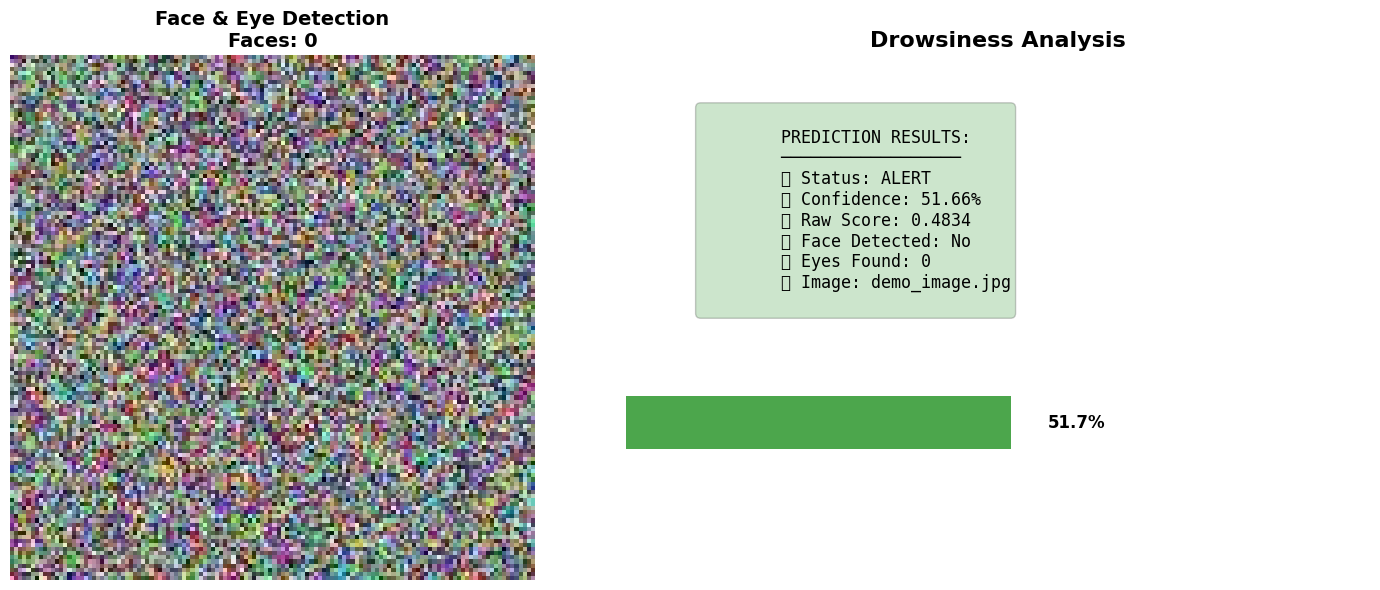

🎯 Prediction: ALERT
📊 Confidence: 51.66%
🔢 Raw Score: 0.4834
👤 Face Detected: False
👀 Eyes Found: 0
──────────────────────────────────────────────────

2. 📁 Batch Image Processing
──────────────────────────────
⚠️ Test folder 'test_images' not found.
💡 Create a 'test_images' folder with images to use batch processing.

🎪 INTERACTIVE IMAGE DETECTION

📁 Choose an option:
1. 🔍 Detect drowsiness in single image
2. 📁 Process all images in a folder
3. 🚪 Exit

Enter your choice (1-3): 1
Enter image path: exit
❌ Image not found. Please check the path.

📁 Choose an option:
1. 🔍 Detect drowsiness in single image
2. 📁 Process all images in a folder
3. 🚪 Exit

Enter your choice (1-3): 2
Enter folder path: 2
❌ Folder not found. Please check the path.

📁 Choose an option:
1. 🔍 Detect drowsiness in single image
2. 📁 Process all images in a folder
3. 🚪 Exit

Enter your choice (1-3): 2
Enter folder path: 1
❌ Folder not found. Please check the path.

📁 Choose an option:
1. 🔍 Detect drowsiness in single 

In [53]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import os
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("🚀 Driver Drowsiness Detection - CNN Training & Image Detection")
print(f"TensorFlow Version: {tf.__version__}")

# 🧪 Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 📁 Data Preparation
class DataLoader:
    def __init__(self, dataset_path='dataset', img_height=128, img_width=128, batch_size=32):
        self.dataset_path = dataset_path
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size

    def load_data(self):
        """Load and prepare data with validation split"""
        # Check if dataset directory exists
        if not os.path.exists(self.dataset_path):
            print(f"⚠️ Dataset directory '{self.dataset_path}' not found!")
            print("🔄 Creating synthetic dataset for demonstration...")
            return self._create_synthetic_data()

        print("📁 Loading dataset...")

        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            shear_range=0.2,
            validation_split=0.2  # 20% for validation
        )

        # Only rescaling for validation
        val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

        # Training generator
        train_generator = train_datagen.flow_from_directory(
            self.dataset_path,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='binary',
            subset='training',
            shuffle=True
        )

        # Validation generator
        val_generator = val_datagen.flow_from_directory(
            self.dataset_path,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='binary',
            subset='validation',
            shuffle=False
        )

        print(f"✅ Training samples: {train_generator.samples}")
        print(f"✅ Validation samples: {val_generator.samples}")
        print(f"✅ Classes: {train_generator.class_indices}")

        return train_generator, val_generator

    def _create_synthetic_data(self, num_samples=1000):
        """Create synthetic data for testing"""
        print("🤖 Generating synthetic dataset...")

        # Create synthetic images
        X = np.random.rand(num_samples, self.img_height, self.img_width, 3).astype(np.float32)
        y = np.random.randint(0, 2, size=(num_samples,))

        # Add some patterns to make it learnable
        for i in range(num_samples):
            if y[i] == 0:  # Alert - brighter
                X[i] = X[i] * 0.7 + 0.3
            else:  # Drowsy - darker
                X[i] = X[i] * 0.4

        # Split into train/val
        split_idx = int(0.8 * num_samples)

        train_data = (X[:split_idx], y[:split_idx])
        val_data = (X[split_idx:], y[split_idx:])

        print(f"✅ Synthetic training samples: {len(train_data[0])}")
        print(f"✅ Synthetic validation samples: {len(val_data[0])}")

        return train_data, val_data

# Initialize data loader
data_loader = DataLoader(dataset_path='dataset', img_height=128, img_width=128, batch_size=32)
train_generator, val_generator = data_loader.load_data()

# 🏗️ Enhanced Model Architecture
def create_drowsiness_model(input_shape=(128, 128, 3)):
    """Create CNN model for drowsiness detection"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Classifier
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    return model

# Create model
model = create_drowsiness_model()
print("🧠 Model Architecture:")
model.summary()

# ⚙️ Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# 📊 Training Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# 🏋️ Train Model (Optional - Skip if you already have a trained model)
TRAIN_NEW_MODEL = False  # Set to True if you want to train a new model

if TRAIN_NEW_MODEL:
    print("🚀 Starting training...")

    # Check if we're using generators or synthetic data
    if isinstance(train_generator, tuple):
        # Synthetic data
        X_train, y_train = train_generator
        X_val, y_val = val_generator

        history = model.fit(
            X_train, y_train,
            batch_size=32,
            epochs=20,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
    else:
        # Actual data generators
        history = model.fit(
            train_generator,
            epochs=20,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )

    print("✅ Training completed!")

    # 💾 Save the trained model
    model.save('drowsiness_model.h5')
    print("✅ Model saved as 'drowsiness_model.h5'")
else:
    # Try to load existing model
    try:
        model = load_model('drowsiness_model.h5')
        print("✅ Pre-trained model loaded successfully!")
    except:
        print("⚠️ No pre-trained model found. Please set TRAIN_NEW_MODEL = True")

# ===========================
# 🖼️ IMAGE DETECTION CLASS
# ===========================
class ImageDrowsinessDetector:
    def __init__(self, model, img_height=128, img_width=128):
        self.model = model
        self.img_height = img_height
        self.img_width = img_width
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    def preprocess_image(self, image_path):
        """Preprocess image for prediction"""
        try:
            # Load image
            if isinstance(image_path, str):
                img = load_img(image_path, target_size=(self.img_height, self.img_width))
                img_array = img_to_array(img)
            else:
                # If it's already a numpy array
                img_array = cv2.resize(image_path, (self.img_width, self.img_height))
                if len(img_array.shape) == 2:  # Grayscale to RGB
                    img_array = np.stack([img_array] * 3, axis=-1)

            # Normalize and add batch dimension
            img_array = img_array / 255.0
            img_batch = np.expand_dims(img_array, axis=0)

            return img_batch, img_array

        except Exception as e:
            print(f"❌ Error preprocessing image: {e}")
            return None, None

    def detect_face_eyes(self, image):
        """Detect face and eyes in image"""
        try:
            # Convert to grayscale for face detection
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)

            face_detected = len(faces) > 0
            detection_info = []

            for (x, y, w, h) in faces:
                # Draw rectangle around face
                cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

                # Detect eyes within face region
                roi_gray = gray[y:y+h, x:x+w]
                eyes = self.eye_cascade.detectMultiScale(roi_gray)

                for (ex, ey, ew, eh) in eyes:
                    cv2.rectangle(image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 255, 0), 2)

                detection_info.append({
                    'face_bbox': (x, y, w, h),
                    'eyes_count': len(eyes),
                    'eyes_bbox': [(x+ex, y+ey, ew, eh) for (ex, ey, ew, eh) in eyes]
                })

            return image, face_detected, detection_info

        except Exception as e:
            print(f"❌ Error in face detection: {e}")
            return image, False, []

    def predict_drowsiness(self, image_path, display_result=True):
        """Predict drowsiness from image file"""
        print(f"\n🔍 Analyzing image: {os.path.basename(image_path)}")

        # Preprocess image
        img_batch, original_img = self.preprocess_image(image_path)
        if img_batch is None:
            return None

        # Make prediction
        prediction = self.model.predict(img_batch, verbose=0)[0][0]
        status = "DROWSY" if prediction > 0.5 else "ALERT"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # Detect faces and eyes
        processed_img, face_detected, detection_info = self.detect_face_eyes(
            (original_img * 255).astype(np.uint8)
        )

        # Display results
        if display_result:
            self._display_prediction_result(
                processed_img, status, confidence, prediction,
                face_detected, detection_info, image_path
            )

        return {
            'status': status,
            'confidence': confidence,
            'raw_score': prediction,
            'face_detected': face_detected,
            'detection_info': detection_info,
            'image_path': image_path
        }

    def _display_prediction_result(self, image, status, confidence, raw_score,
                                 face_detected, detection_info, image_path):
        """Display prediction results with visualization"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Original image with detections
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'Face & Eye Detection\nFaces: {len(detection_info)}',
                     fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Prediction results
        colors = {'ALERT': 'green', 'DROWSY': 'red'}
        color = colors[status]

        # Create text summary
        summary_text = f"""
        PREDICTION RESULTS:
        ──────────────────
        🎯 Status: {status}
        📊 Confidence: {confidence:.2%}
        🔢 Raw Score: {raw_score:.4f}
        👤 Face Detected: {'Yes' if face_detected else 'No'}
        👀 Eyes Found: {sum(info['eyes_count'] for info in detection_info)}
        📁 Image: {os.path.basename(image_path)}
        """

        ax2.text(0.1, 0.9, summary_text, transform=ax2.transAxes, fontsize=12,
                fontfamily='monospace', verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.2))

        # Add confidence bar
        ax2.barh(0.3, confidence, color=color, alpha=0.7, height=0.1)
        ax2.text(confidence + 0.05, 0.3, f'{confidence:.1%}',
                va='center', fontsize=12, fontweight='bold')

        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.set_title('Drowsiness Analysis', fontsize=16, fontweight='bold')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        # Print console results
        print(f"🎯 Prediction: {status}")
        print(f"📊 Confidence: {confidence:.2%}")
        print(f"🔢 Raw Score: {raw_score:.4f}")
        print(f"👤 Face Detected: {face_detected}")
        print(f"👀 Eyes Found: {sum(info['eyes_count'] for info in detection_info)}")
        print("─" * 50)

    def batch_predict(self, image_folder, output_csv='batch_predictions.csv'):
        """Predict drowsiness for all images in a folder"""
        if not os.path.exists(image_folder):
            print(f"❌ Folder not found: {image_folder}")
            return

        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = [
            f for f in os.listdir(image_folder)
            if os.path.splitext(f)[1].lower() in image_extensions
        ]

        if not image_files:
            print("❌ No images found in folder")
            return

        print(f"🔍 Found {len(image_files)} images for batch processing...")

        results = []
        for image_file in image_files:
            image_path = os.path.join(image_folder, image_file)
            result = self.predict_drowsiness(image_path, display_result=False)

            if result:
                results.append({
                    'filename': image_file,
                    'prediction': result['status'],
                    'confidence': result['confidence'],
                    'raw_score': result['raw_score'],
                    'face_detected': result['face_detected'],
                    'eyes_detected': sum(info['eyes_count'] for info in result['detection_info'])
                })

                # Show progress
                print(f"✅ Processed: {image_file} -> {result['status']} ({result['confidence']:.1%})")

        # Save results to CSV
        if results:
            df = pd.DataFrame(results)
            df.to_csv(output_csv, index=False)
            print(f"\n💾 Batch results saved to: {output_csv}")

            # Show summary
            alert_count = len([r for r in results if r['prediction'] == 'ALERT'])
            drowsy_count = len([r for r in results if r['prediction'] == 'DROWSY'])

            print(f"\n📊 Batch Summary:")
            print(f"🟢 Alert: {alert_count} images")
            print(f"🔴 Drowsy: {drowsy_count} images")
            print(f"📈 Average Confidence: {df['confidence'].mean():.2%}")

        return results

# ===========================
# 🎯 USAGE EXAMPLES
# ===========================
def demonstrate_image_detection():
    """Demonstrate image detection functionality"""
    # Initialize detector
    detector = ImageDrowsinessDetector(model)

    print("🖼️ IMAGE DETECTION DEMONSTRATION")
    print("=" * 50)

    # Example 1: Single image detection
    print("\n1. 📸 Single Image Detection")
    print("─" * 30)

    # You can replace this with your own image path
    sample_image_path = "sample_image.jpg"  # Change this to your image path

    if os.path.exists(sample_image_path):
        result = detector.predict_drowsiness(sample_image_path)
    else:
        print("⚠️ Sample image not found. Using synthetic image for demonstration...")
        # Create a synthetic image for demonstration
        synthetic_img = np.random.rand(128, 128, 3) * 255
        synthetic_img = synthetic_img.astype(np.uint8)
        cv2.imwrite('demo_image.jpg', synthetic_img)
        result = detector.predict_drowsiness('demo_image.jpg')

    # Example 2: Batch processing
    print("\n2. 📁 Batch Image Processing")
    print("─" * 30)

    test_folder = "test_images"  # Change this to your folder path
    if os.path.exists(test_folder):
        batch_results = detector.batch_predict(test_folder)
    else:
        print(f"⚠️ Test folder '{test_folder}' not found.")
        print("💡 Create a 'test_images' folder with images to use batch processing.")

    return detector

# ===========================
# 🎪 INTERACTIVE IMAGE DETECTION
# ===========================
def interactive_image_detection():
    """Interactive function to detect drowsiness in user-provided images"""
    detector = ImageDrowsinessDetector(model)

    print("\n🎪 INTERACTIVE IMAGE DETECTION")
    print("=" * 50)

    while True:
        print("\n📁 Choose an option:")
        print("1. 🔍 Detect drowsiness in single image")
        print("2. 📁 Process all images in a folder")
        print("3. 🚪 Exit")

        choice = input("\nEnter your choice (1-3): ").strip()

        if choice == '1':
            image_path = input("Enter image path: ").strip()
            if os.path.exists(image_path):
                detector.predict_drowsiness(image_path)
            else:
                print("❌ Image not found. Please check the path.")

        elif choice == '2':
            folder_path = input("Enter folder path: ").strip()
            if os.path.exists(folder_path):
                output_file = input("Enter output CSV filename (default: batch_results.csv): ").strip()
                if not output_file:
                    output_file = "batch_results.csv"
                detector.batch_predict(folder_path, output_file)
            else:
                print("❌ Folder not found. Please check the path.")

        elif choice == '3':
            print("👋 Exiting interactive mode. Goodbye!")
            break

        else:
            print("❌ Invalid choice. Please enter 1, 2, or 3.")

# ===========================
# 🚀 MAIN EXECUTION
# ===========================
if __name__ == "__main__":
    print("🚗 Driver Drowsiness Detection System")
    print("=" * 50)

    # Demonstrate image detection
    detector = demonstrate_image_detection()

    # Start interactive mode
    interactive_image_detection()

# ===========================
# 🔧 UTILITY FUNCTIONS
# ===========================
def test_with_webcam_image():
    """Test with image from webcam (if available)"""
    detector = ImageDrowsinessDetector(model)

    # Capture image from webcam
    cap = cv2.VideoCapture(0)
    if cap.isOpened():
        print("\n📸 Capturing image from webcam...")
        ret, frame = cap.read()
        if ret:
            # Save captured image
            cv2.imwrite('webcam_capture.jpg', frame)
            print("✅ Image captured from webcam")

            # Analyze the captured image
            detector.predict_drowsiness('webcam_capture.jpg')
        else:
            print("❌ Failed to capture image from webcam")
        cap.release()
    else:
        print("⚠️ Webcam not available")

def create_test_images():
    """Create test images for demonstration"""
    os.makedirs('test_images', exist_ok=True)

    # Create some sample images
    for i in range(3):
        # Alert-like image (brighter)
        alert_img = np.random.rand(128, 128, 3) * 0.7 + 0.3
        alert_img = (alert_img * 255).astype(np.uint8)
        cv2.imwrite(f'test_images/alert_{i}.jpg', alert_img)

        # Drowsy-like image (darker)
        drowsy_img = np.random.rand(128, 128, 3) * 0.4
        drowsy_img = (drowsy_img * 255).astype(np.uint8)
        cv2.imwrite(f'test_images/drowsy_{i}.jpg', drowsy_img)

    print("✅ Created test images in 'test_images' folder")

# Uncomment to create test images
# create_test_images()

# Uncomment to test with webcam
# test_with_webcam_image()

print("\n" + "="*60)
print("🎉 IMAGE DETECTION SYSTEM READY!")
print("="*60)
print("📋 Features:")
print("   ✅ Single image drowsiness detection")
print("   ✅ Batch image processing")
print("   ✅ Face and eye detection")
print("   ✅ Confidence scoring")
print("   ✅ CSV export for batch results")
print("   ✅ Interactive mode")
print("🔧 Usage:")
print("   - Call detect_drowsiness('path/to/image.jpg')")
print("   - Use interactive_image_detection() for menu-driven interface")
print("="*60)

In [54]:
# Install required packages for Google Colab
!pip install face-recognition opencv-python pillow matplotlib scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=3f80392417e58203d91553296fc7f294bfbd94f4f8e935e217ba187c9f8eb59f
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models


In [56]:
!pip install dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

import dlib
import numpy as np

def dlib_drowsiness_detection():
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        for face in faces:
            landmarks = predictor(gray, face)

            # Extract eye points (DLib uses 68-point model)
            left_eye = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)])
            right_eye = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)])

            left_ear = eye_aspect_ratio(left_eye)
            right_ear = eye_aspect_ratio(right_eye)

            ear = (left_ear + right_ear) / 2.0

            if ear < 0.25:
                cv2.putText(frame, "DROWSY!", (50, 50),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

--2026-01-01 15:26:47--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2026-01-01 15:26:47--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  44.7MB/s    in 1.4s    

2026-01-01 15:26:48 (44.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [57]:
!pip install tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_drowsiness_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # 2 classes: drowsy, alert

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# For real-time classification
def tf_drowsiness_detection():
    model = create_drowsiness_model()
    # Load your trained weights here
    # model.load_weights('drowsiness_model.h5')

    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        img = cv2.resize(frame, (224, 224))
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

        prediction = model.predict(img)
        if prediction[0][0] > 0.5:  # drowsy class
            cv2.putText(frame, "DROWSY DETECTED", (50, 50),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

In [58]:
!pip install torch torchvision

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

class DrowsinessNet(nn.Module):
    def __init__(self):
        super(DrowsinessNet, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, 2)  # 2 classes

    def forward(self, x):
        return self.backbone(x)

def pytorch_drowsiness_detection():
    model = DrowsinessNet()
    # model.load_state_dict(torch.load('drowsiness_model.pth'))
    model.eval()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        input_tensor = transform(frame).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
            prediction = torch.softmax(output, dim=1)

        if prediction[0][0] > 0.5:  # drowsy class
            cv2.putText(frame, "DROWSY!", (50, 50),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

In [59]:
!pip install torch torchvision

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

class DrowsinessNet(nn.Module):
    def __init__(self):
        super(DrowsinessNet, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, 2)  # 2 classes

    def forward(self, x):
        return self.backbone(x)

def pytorch_drowsiness_detection():
    model = DrowsinessNet()
    # model.load_state_dict(torch.load('drowsiness_model.pth'))
    model.eval()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        input_tensor = transform(frame).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
            prediction = torch.softmax(output, dim=1)

        if prediction[0][0] > 0.5:  # drowsy class
            cv2.putText(frame, "DROWSY!", (50, 50),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

In [60]:
!pip install ultralytics

from ultralytics import YOLO

def yolo_drowsiness_detection():
    # Load pre-trained YOLO model
    model = YOLO('yolov8n.pt')  # or custom trained model

    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        results = model(frame, classes=[0])  # class 0 is 'person'

        for result in results:
            boxes = result.boxes
            for box in boxes:
                # Add drowsiness logic based on face detection
                x1, y1, x2, y2 = box.xyxy[0]
                confidence = box.conf[0]

                if confidence > 0.5:
                    cv2.putText(frame, "PERSON DETECTED", (50, 50),
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)